In [2]:
pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 3.7 MB/s eta 0:00:01
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp38-cp38-macosx_10_9_x86_64.whl size=758747 sha256=e529fe0ca149b978ab778d341012604a45f39032e6563dc54f7f52f5ece6ccbb
  Stored in directory: /Users/nasim/Library/Caches/pip/wheels/20/91/57/2965d4cff1b8ac7ed1b6fa25741882af3974b54a31759e10b6
Successfully built scikit-surprise
Note: you may need to restart the kernel to use updated packages.


In [1]:
from surprise import BaselineOnly
from surprise import NMF
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
import os
from surprise import accuracy
from surprise.model_selection import KFold
# from surprise import SVD
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime
import random
from time import time
import math

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from multiprocessing import Pool
import timeit

my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

Splitting the data using the *userfixed* method, where 80% of each user's data goes to training and the rest to testing set. Surprises split method is randomly. Their method is extended below.

In [3]:
class RatingDataset:
    import numpy as np
    from scipy import sparse
    
    def __init__(self):
        self.rating_mat = None
        self.time_mat = None
        self._data_file_path = ''
        
        # list of raw user_IDs (dataset IDs)
        self.items = []
        self.users = []
        self.item_n = 0
        self.user_n = 0
        
        # maps raw user_id to user_iid(or innder id)
        self.user_to_iid = {}
        # maps user inner id to dataset raw ID
        self.user_to_ID = {}
        # maps raw item_id (dataset) to item_iid(or inner id)
        self.item_to_iid = {}
        # maps item inner id to dataset raw ID
        self.item_to_ID = {}
        
        # list of triples of (item, rating, timestamp) for each user_iid. 
        # TODO: In case there were no Timestamp in the data, pairs of (item, rating) will be kept
        self.user_ratings = []
        # list of pair of (user, rating) for each item_iid
        self.item_ratings = []
        
        
    def __get_line_format_indices(self, line_format):
        # specifying the order of 'user, item, rating, timestamp' in each line 
        lf_sp = line_format.split(' ')
        if len(lf_sp) != 4:
            raise Exception('''Bad line format!
            line_format should be space-separated and it should always specified by 
            "user item rating timestamp" with any order!''')
        user_idx = -1
        item_idx = -1
        rating_idx = -1
        timestamp_idx = -1
        for c in range(len(lf_sp)):
            if lf_sp[c] == 'user':
                user_idx = c
            elif lf_sp[c] == 'item':
                item_idx = c
            elif lf_sp[c] == 'rating':
                rating_idx = c
            elif lf_sp[c] == 'timestamp':
                timestamp_idx = c
            else:
                raise Exception('line_format must be exactly dictated by one of: (user/item/rating/timestamp) separated by sep!')
        
        return user_idx, item_idx, rating_idx, timestamp_idx
    
    
    '''
        Read the rating data from file and parse it and then make the dataset.
    '''
    def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating timestamp'):
        
        user_fmt_idx, item_fmt_idx, rating_fmt_idx, timestamp_fmt_idx = self.__get_line_format_indices(line_format)
        
        file = open(data_fn, 'r')
        
        # skip lines that are specified from input
        for _ in range(skip_lines):
            file.readline()
            
        # users list as in input file
        users_lin = []
        items_lin = []
        ratings_lin = []
        timestamps_lin = []
        for l in file:
            lsp = l.split(sep)
            user_id = lsp[user_fmt_idx]
            item_id = lsp[item_fmt_idx]
            rating = float(lsp[rating_fmt_idx])
            timestamp = int(lsp[timestamp_fmt_idx].strip('\n'))
            
            users_lin.append(user_id)
            items_lin.append(item_id)
            ratings_lin.append(rating)
            timestamps_lin.append(timestamp)
            
        self.users = list(set(users_lin))
        self.items = list(set(items_lin))
        
        self.user_n = len(self.users)
        self.item_n = len(self.items)
        
        # set the mappings
        for idx in range(self.user_n): 
            self.user_to_iid[self.users[idx]] = idx
        for idx in range(self.user_n):
            self.user_to_ID[idx] = self.users[idx] 
        for idx in range(self.item_n):
            self.item_to_iid[self.items[idx]] = idx 
        for idx in range(self.item_n):
            self.item_to_ID[idx] = self.items[idx] 
        
        # init rating matrix
        self.rating_mat = sparse.lil_matrix((self.user_n, self.item_n))
        self.time_mat = sparse.lil_matrix((self.user_n, self.item_n))
        for idx in range(len(users_lin)):
            user_iid = self.user_to_iid[users_lin[idx]]
            item_iid = self.item_to_iid[items_lin[idx]]
            rating = ratings_lin[idx]
            self.rating_mat[user_iid, item_iid] = rating
            self.time_mat[user_iid, item_iid] = timestamps_lin[idx]
            
            
    def list_users_ratings(self, rating_matrix):
        # finding the user and item ratings
        user_ratings = []
        for user_iid in range(self.user_n):
            # append a list for this user
            user_ratings.append([])
            user_nonze = np.nonzero(rating_matrix[user_iid])
            for item_iid in user_nonze[1]:
                # add items and its rating into the last user added to the list
                user_ratings[-1].append((item_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return user_ratings
    
            
    def list_items_ratings(self, rating_matrix):
        item_ratings = []
        for item_iid in range(self.item_n):
            # append a list for this item
            item_ratings.append([])
            item_nonze = np.nonzero(rating_matrix.T[item_iid])
            for user_iid in item_nonze[1]:
                # add users and its rating into the last item added to the list
                item_ratings[-1].append((user_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return item_ratings
        
            
    def train_test_split(self, test_percent=0.2, least_userlen_test=10):
        if test_percent > 1:
            raise Exception('test_percent should be between 0 and 1.')
            
        user_ratings = self.list_users_ratings(self.rating_mat)
        
        mat = sparse.lil_matrix((self.user_n, self.item_n))
        user_tests = {}
        n_users_in_test = 0
        n_ratings_in_test = 0
        n_ratings_in_train = 0
        
        for user_iid in range(self.user_n):
            len_u = len(user_ratings[user_iid])
            if len_u >= least_userlen_test:
                n_users_in_test += 1
                test_len = int(len_u * test_percent)
                test_set_u = list(range(len_u))
#                 print(test_len, len_u)
                random.shuffle(test_set_u)
                
                train_set_u = test_set_u[test_len:][:]
                test_set_u = test_set_u[:test_len][:]
                
#                 print(len(train_set_u))
                
                for ir_idx in train_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
                
                user_tests[user_iid] = []
                for ir_idx in test_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    user_tests[user_iid].append(ir)
                    n_ratings_in_test += 1
                    
            else: # if no test set should be seprated from ratings of this user
                for ir in user_ratings[user_iid]:
                    # ir = the pair of (item, rating)
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
    
        print('Number of users with some items in testset: %d' % n_users_in_test)
        print('Number of ratings in trainset: %d \t Number of ratings in testset: %d' % (n_ratings_in_train, n_ratings_in_test))
        return mat, user_tests

# Load the data here.

A sample of The Movies Dataset was created and imported here. The data file is provided.
The Movies dataset is the MovieLens dataset but with features. It was downloaded from here:
https://www.kaggle.com/rounakbanik/the-movies-dataset

In [4]:
dataset = RatingDataset()
data_fn = 'data/ml_sample_6000.dat'
dataset.read_from_file(data_fn, skip_lines=0, line_format='user item rating timestamp', sep=',')

In [5]:
print(dataset.user_n)
print(dataset.item_n)

6000
14623


# Splitting the data to training and test sets

In [6]:
train_mat, user_tests = dataset.train_test_split(test_percent=0.2, least_userlen_test=10)

Number of users with some items in testset: 5193
Number of ratings in trainset: 449814 	 Number of ratings in testset: 109256


In [7]:
user_ratings = dataset.list_users_ratings(dataset.rating_mat)

In [8]:
dataset.rating_mat.shape

(6000, 14623)

# Saving the training and test sets for evaluation purposes (in another Ipython Notebook).

In [9]:
# test set
u_t_list = []

for uid in user_tests.keys():
    base_rec = pd.DataFrame(user_tests[uid])
    base_rec[2] = uid
    u_t_list.append(base_rec[[2,0,1]])

u_t_df = pd.concat(u_t_list, ignore_index=True)
u_t_df.to_csv('./data/test_recs_ml.csv', index=False, header=None)

In [10]:
np.save('./data/trainmatrix_ml.npy', train_mat.toarray())

# A brief evaluation of the baseline recommendation

- Time-based nDCG, Recall, Precision

- mat: is the *training data* and is a sparse matrix

- user_tests: is a dictionary for each user(key) stores the set of items that is positively rated(>= 4stars) by this user.

In [11]:
import math
# ground_truth: list of items ordered by time
def nDCG_Time(ground_truth, _recList):
    rec_num = len(_recList) # topK
    # ground_truth is already sorted by time
    idealOrder = ground_truth
    idealDCG = 0.0
    for j in range(min(rec_num, len(idealOrder))):
        idealDCG += ((math.pow(2.0, len(idealOrder) - j) - 1) / math.log(2.0 + j))

    recDCG = 0.0
    for j in range(rec_num):
        item = _recList[j]
        if item in ground_truth:
            rank = len(ground_truth) - ground_truth.index(item) # why ground truth?
            recDCG += ((math.pow(2.0, rank) - 1) / math.log(1.0 + j + 1))

    return (recDCG / idealDCG)


def Recall(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_test_set))


def Precision(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_recList))


# Reading item-feature matrix

The following features were selected among all the features: genres, popularity, year, revenue, runtime, language, production countries. All of them were first turned into categorical variables. For example, if the runtime of a movie is less than the median of the runtime of all the movies, its value is set to short, otherwise long. Please refer to the paper for more explanation on the data preprocessing: https://dl.acm.org/doi/abs/10.1145/3340631.3394846

In [12]:
feat_dict = {'genres': ['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie', 'Adult'], 'popularity': ['pop', 'notpop'], 'year': ['new', 'old'], 'revenue': ['high', 'low'], 'runtime': ['short', 'long'], 'language': ['en', 'fr', 'es', 'de', 'ru', 'la', 'nl', 'cn', 'zh', 'hu', 'sq', 'it', 'ko', 'fa', 'da', 'gd', 'ja', 'ar', 'hr', 'bs', 'mn', 'ro', 'id', 'ms', 'mk', 'sv', 'he', 'kw', 'cs', 'nv', 'mi', 'tl', 'pl', 'ga', 'no', 'sk', 'vi', 'yi', 'pt', 'hi', 'ca', 'is', 'af', 'sr', 'bn', 'wo', 'cy', 'th', 'lv', 'sw', 'bg', 'el', 'ne', 'tr', 'km', 'fi', 'eo', 'uk', 'iu', 'ka', 'sh', 'bo', 'nb', 'ty', 'xx', 'si', 'as', 'gn', 'eu', 'az', 'mt', 'ur', 'zu', 'lo', 'xh', 'bm', 'cr', 'ps', 'so', 'ku', 'hy', 'oc', 'pa', 'to', 'ce', 'qu', 'be', 'am', 'tg', 'tt', 'se', 'ml', 'ta', 'co', 'gl', 'dz', 'rw', 'ht', 'kk', 'ln', 'my', 'et', 'sa', 'lt', 'fy', 'tk', 'sl', 'te', 'ny', 'st', 'sc', 'gu', 'ff', 'mr', 'ug', 'ay', 'ky', 'jv', 'br', 'sg', 'lb', 'ab', 'kn', 'uz', 'sm', 'ki', 'tn', 'fo', 'sn', 'bi', 'ha', 'ig', 'mh'], 'production_countries': ['US', 'DE', 'GB', 'FR', 'IT', 'ES', 'CN', 'AU', 'ZA', 'CA', 'CH', 'BE', 'JP', 'IR', 'NL', 'HK', 'TN', 'IE', 'DO', 'HR', 'RU', 'MK', 'AT', 'TW', 'NZ', 'MX', 'PL', 'PE', 'CU', 'LI', 'DK', 'PT', 'FI', 'SE', 'AR', 'IS', 'KR', 'RS', 'HU', 'CZ', 'IN', 'BR', 'GR', 'CD', 'SN', 'BF', 'RO', 'PH', 'VN', 'TT', 'BG', 'CL', 'NO', 'KZ', 'DZ', 'LU', 'GE', 'UA', 'BW', 'AW', 'IL', 'TR', 'EC', 'LB', 'MA', 'BA', 'BS', 'MY', 'BT', 'JM', 'PK', 'NP', 'CI', 'TH', 'NA', 'CM', 'CO', 'XC', 'UY', 'SI', 'LY', 'PR', 'SU', 'XG', 'SG', 'AF', 'MT', 'PA', 'EG', 'ZW', 'TJ', 'UZ', 'CR', 'KW', 'MQ', 'GH', 'AM', 'ID', 'MN', 'BO', 'MC', 'IQ', 'SK', 'CS', 'VE', 'LT', 'RW', 'PS', 'TD', 'PY', 'QA', 'EE', 'MO', 'ML', 'UM', 'LV', 'AE', 'AZ', 'KY', 'NI', 'LR', 'YU', 'ME', 'AO', 'BY', 'KH', 'MR', 'CY', 'BD', 'SY', 'KG', 'AL', 'TZ', 'KP', 'KE', 'JO', 'UG', 'SA', 'SO', 'GT', 'MG', 'ET', 'LK', 'PG', 'NG', 'LA', 'PF', 'AN', 'CG', 'MM', 'BM', 'SV', 'TF', 'WS', 'MD', 'BB', 'AQ', 'GI', 'BN', 'HN', 'GN']}

In [13]:
item_features_df = pd.read_csv('./data/movie_genre_matrix.csv')
item_features_df.set_index('movieid', inplace=True)
print(item_features_df.head())

           AE  AF  AL  AM  AN  AO  AQ  AR  AT  AU  ...  uk  ur  uz  vi  wo  \
movieid                                            ...                       
tt0000001   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
tt0000003   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
tt0000005   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
tt0000008   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
tt0000010   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   

           xh  xx  yi  zh  zu  
movieid                        
tt0000001   0   1   0   0   0  
tt0000003   0   1   0   0   0  
tt0000005   0   1   0   0   0  
tt0000008   0   1   0   0   0  
tt0000010   0   1   0   0   0  

[5 rows x 323 columns]


In [14]:
genres = ['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 
          'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 
          'Music', 'Documentary', 'Western', 'TV Movie', 'Adult']

In [15]:
cols = list(item_features_df.columns)
cols.index('Drama')

51

### Some of the movies weren't assigned to any genres. Therefore to fill in the missing values, we add drama as the genre of those movies which does not have any genre labels.

In [16]:
# we assign drama if the sum of genre values for a movie is zero
for idx, row in item_features_df.iterrows():
    if np.sum(row.loc[genres]) == 0:
        row.loc['Drama'] = 1

### Handling inner_ID (in the dataset) to innerid for the item-item similarity matrix.

In [17]:
# Turning inner_ID to innerid for this item item similarity matrix
InnerID_to_iiMatrixID = {}
iiMatrixID_to_InnerID = {}

for i in range(item_features_df.shape[0]):
    iiMatrixID_to_InnerID[i] = item_features_df.index[i]
    InnerID_to_iiMatrixID[item_features_df.index[i]] = i


In [18]:
len(InnerID_to_iiMatrixID)

45332

In [19]:
len(iiMatrixID_to_InnerID)

45332

### Generating the item-item similarity matrix based on the features matrix calculated before (cell 13).

In [20]:
# calcualte the item-item similarity matrix by its features
from sklearn.metrics.pairwise import cosine_similarity

itemItemSimilarityByFeature = cosine_similarity(item_features_df.values)
# its shape is (45332, 45332)

In [21]:
itemItemSimilarityByFeature.shape

(45332, 45332)

example

In [22]:
itemItemSimilarityByFeature[0, 1]

0.6681531047810608

# Creating a mapping from item-id and item-imdb ids

In [23]:
imdb_ii = list(item_features_df.index)
from_imdb_itemSim = {}
from_itemSim_imdb = {}
for i in range(len(imdb_ii)):
    from_imdb_itemSim[imdb_ii[i]] = i
    from_itemSim_imdb[i] = imdb_ii[i]

In [24]:
import pandas as pd

df_meta = pd.read_csv('data/movies_metadata.csv', header=0, low_memory=False)
df_links = pd.read_csv('data/links.csv', header=0)
mv_id_to_imdb = {}

for idx, row in df_links.iterrows():
    mv_id_to_imdb[row[0]] = 'tt' + str(int(row[1])).zfill(7)
movie_all_ids = df_meta['id'].to_list()

def item_iid_to_imdb(item_iid):
    return mv_id_to_imdb[int(dataset.item_to_ID[item_iid])]


print(item_iid_to_imdb(2069))
df_meta[df_meta['imdb_id'] == str(item_iid_to_imdb(2069))]

tt0417741


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
13893,False,"{'id': 1241, 'name': 'Harry Potter Collection'...",250000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://harrypotter.warnerbros.com/harrypottera...,767,tt0417741,en,Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he...",...,2009-07-07,933959197.0,153.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Dark Secrets Revealed,Harry Potter and the Half-Blood Prince,False,7.4,5435.0


## Adding movielens ids to this dataframe

In [25]:
imdb_to_movie_id = {}
mv_id_to_imdb_keys = list(mv_id_to_imdb.keys())
mv_id_to_imdb_values = list(mv_id_to_imdb.values())

item_features_df_mvId_imdb = item_features_df.copy()
item_features_df_mvId_imdb['MovieLensID'] = -1

e = 0
for idx, row in item_features_df_mvId_imdb.iterrows():
    try:
        mv_id = mv_id_to_imdb_keys[mv_id_to_imdb_values.index(idx)]
        row[-1] = mv_id
    except ValueError:
        e += 1
print(e, len(item_features_df_mvId_imdb))
item_features_df_mvId_imdb.head(1)

60 45332


,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,...,ur,uz,vi,wo,xh,xx,yi,zh,zu,MovieLensID
movieid,,,,,,,,,,,,,,,,,,,,,
tt0000001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,172063


## Adding Inner item IDs to the feature data frame

In [26]:
item_features_df_mvId_imdb['Inner_ID'] = -1
e = 0
for idx, row in item_features_df_mvId_imdb.iterrows():
    try:
        row['Inner_ID'] = dataset.item_to_iid[str(row.loc['MovieLensID'])]
    except KeyError:
        e += 1
print(e, len(item_features_df_mvId_imdb) - e)
item_features_df_mvId_imdb.head(1)

30841 14491


,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,...,uz,vi,wo,xh,xx,yi,zh,zu,MovieLensID,Inner_ID
movieid,,,,,,,,,,,,,,,,,,,,,
tt0000001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,172063,-1


# Keeping only those movies which are in the sampled dataset.

The features data is created for all of the items, but I sampled the rating data. Therefore we need to pick only the items that exist in the sampled dataset.

In [27]:
item_features_sampled = item_features_df_mvId_imdb[item_features_df_mvId_imdb['Inner_ID'] != -1].copy()

In [28]:
item_features_sampled.head(2)

,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,...,uz,vi,wo,xh,xx,yi,zh,zu,MovieLensID,Inner_ID
movieid,,,,,,,,,,,,,,,,,,,,,
tt0000417,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,32898,12307
tt0000420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,161111,6252


In [29]:
selected_cols = [item_features_sampled.columns[-1]] + item_features_sampled.columns[:-2].tolist()
# selected_cols[:5]

## saving the whole dataframe and all the ids.

In [30]:
item_features_sampled[selected_cols].to_csv('./data/movie_iid_features_sampled.csv', index=False)

In [31]:
item_features_sampled.head(2)

,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,...,uz,vi,wo,xh,xx,yi,zh,zu,MovieLensID,Inner_ID
movieid,,,,,,,,,,,,,,,,,,,,,
tt0000417,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,32898,12307
tt0000420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,161111,6252


The original count of items

In [32]:
item_features_df.index.shape

(45332,)

The count of items in the sampled dataset

In [33]:
item_features_sampled.index.shape

(14491,)

# Keeping only Inner_ID and the features. Removing other ids.

In [34]:
item_features_sampled.set_index('Inner_ID', inplace=True)
item_features_sampled_2 = item_features_sampled[item_features_df.columns].copy()

In [35]:
item_features_sampled_2.head(2)

,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
Inner_ID,,,,,,,,,,,,,,,,,,,,,
12307,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [36]:
item_features_sampled_2.index.shape

(14491,)

# The base recommender is Non-negative Matrix Factorization (NMF) here, but it can be any recommender algorithm.

In [37]:
def recNMF_2(user_iid, _est, mat, topk):
    
    rated_before = np.nonzero(mat[user_iid, :])[1]
    estimations = _est[user_iid]
    estimations[rated_before] = 0 
    # you don't want to recommend the items to the user that have rated before duh!
    
    # top_items = np.argpartition(-estimations, topk)[:topk]
    top_items = np.argsort(-estimations)[:topk]
    top_ratings = -np.sort(-estimations)[:topk]
    
    return (user_iid, top_items, top_ratings)

# Baseline : NMF RECSYS

In [38]:
start = timeit.default_timer()
from sklearn.decomposition import NMF
feature_n = 40

mf = NMF(n_components=feature_n, init='random', random_state=2, tol=0.01,
         solver='cd', max_iter=1000, alpha=1, beta_loss='frobenius',
         l1_ratio=0)

user_f = mf.fit_transform(train_mat)
H = mf.components_
item_f = mf.components_.T

stop = timeit.default_timer()
print('Process Time: %.2f secs' % (stop - start))
start = timeit.default_timer()
est = np.dot(user_f, item_f.T)
res = []

# Choose it to be 1000 instead of 10, and then the re-ranker will chose the final top 10
for u in range(dataset.user_n):
    res.append(recNMF_2(u, est, train_mat, 200))
    
user_recs_allinclude = {}
for x in res:
    user_recs_allinclude[x[0]] = x[1]

Process Time: 2.74 secs


## Saving the base recommendations into a file

In [39]:
u_rec_list = []
for i in range(len(res)):
    base_rec = pd.DataFrame(res[i][1:]).T
    base_rec[2] = res[i][0]
    u_rec_list.append(base_rec[[2,0,1]])

u_rec_df = pd.concat(u_rec_list, ignore_index=True)
u_rec_df.to_csv('./ml_results/nmf_base_rec_ML.csv', index=False, header=None)

## Evaluation of the base recommender system

It needs paramter tuning to get the best results.

In [40]:
stop = timeit.default_timer()
print('Process Time: %.2f secs' % (stop - start))

p = []
r = []
n = []

for u in user_tests.keys():
    if len(user_tests[u]) > 0:
        
        test_items = [t[0] for t in user_tests[u] if t[1] >= 4]
        
        if len(test_items) > 0:
            # to be comparable with the other algorithms, the list size should be the same that is 10 here.
            top_items = user_recs_allinclude[u][:10] 
            
            recall = Recall(test_items, top_items)
            precision = Precision(test_items, top_items)
            ndcg = nDCG_Time(test_items, top_items)

            p.append(precision)
            r.append(recall)
            n.append(ndcg)

print (" avg-precision %.3f\n avg-recall %.3f\n avg-nDCG %.3f" %
       (np.average(p),np.average(r),np.average(n)))

Process Time: 95.93 secs
 avg-precision 0.160
 avg-recall 0.189
 avg-nDCG 0.122


## Note
- User_recs_allinclude is a dictionary where the key is userid and the value is the top k recommendations
- We will pick the first 100 items in for each user to feed into the reranker.

# RECSYS + MMR RE-RANKER

Here, we take the recommendations of the base recommender system (NMF), and rerank the results based on Maximal Marginal Relevance(MMR) with the following formula.

lambda * recommendation score - (1 - lambda) * cosine similarity

In [1]:
import numpy as np
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler

The following algorithm is used throught the paper. It can work as a simple MMR and all the otehr baselines and also as OFAiR as well if it is passed a weight vector.

In [2]:
import warnings
warnings.filterwarnings("error")
import sklearn

# u is userid, items of that user
# items is the list of all item-features
def mmr_opt(u, item_features, lam, top_k, w=None):
    
    new_rec_i = []
    new_rec_sc = []
    for i in range(len(res[u][1])):
        if res[u][1][i] in item_features.index:
            new_rec_i.append(res[u][1][i])
            new_rec_sc.append(res[u][2][i])
    new_rec_i = np.array(new_rec_i)
    new_rec_sc = np.array(new_rec_sc)
    
    # making sure that the scores are between zero and one across all users, similar to cosine score
    # otherwise how do we combine these two different scores
    scaler = MinMaxScaler()
    # scale the ratings for each user separately, does it matter at all?
    scaled_ratings = scaler.fit_transform(new_rec_sc.reshape(-1,1))[:,0]
    
    
    if w is not None:
        dists = sklearn.metrics.pairwise_distances(np.sqrt(w) * item_features.loc[new_rec_i], metric='cosine', n_jobs=1)
    else:
        dists = sklearn.metrics.pairwise_distances(item_features.loc[new_rec_i], metric='cosine', n_jobs=1)    


    c = 0
    s = []
    for k in range(top_k): # top_k means choose top k items for the final re-ranking.
        all_sc = []
        # iterate through the items that are recommended to user.
        # we choose the first 200 items.
        for rec_idx in range(len(new_rec_i)):
            p2 = 0
            for j in s:
                try:

                    # comparing item features
                    # items[i], items[j] and w are all vectors
                    # w is a vector the same length as items[i] and items[j]
                    p = 1 - dists[rec_idx, new_rec_i.tolist().index(j)]
                    p2 += p
                except KeyError as e:
                    pass
              
                    
            
            # mmr objective function
            # sc = lam * (1 - distance.cosine(u, items[i])) - (1-lam) * p2
            r = scaled_ratings[rec_idx]
            
            # get the index of an itemid and get the rating related to it
            sc = lam * r - (1-lam) * p2
            # find the index of a user id and then go to that index to retrieve the score
            all_sc.append(sc) # 0.1 0.5 0.2
            
            
            
        sc_asorted = np.argsort(all_sc)[::-1] #[1, 2, 0]
        sc_idx = 0
        top_item = new_rec_i[sc_asorted[0]]
        
        # if top item already exists in the list, pick the second best item or the third best item
        while top_item in s:
            top_item = new_rec_i[sc_asorted[sc_idx]]
            sc_idx += 1
        s.append(top_item)

    top_ratings = [new_rec_sc[list(new_rec_i).index(i)] for i in s]
    
    return (u, s, top_ratings)

## NOTE: we need to tune the parameter Lambda wich controls the tradeoff between diversity and accuracy

## saving the results of recsys+mmr

In [ ]:
def save_recommendations(recommendations, filename):
    u_rec_list = []
    for i in range(len(recommendations)):
        base_rec = pd.DataFrame(recommendations[i][1][1:]).T
        base_rec[2] = recommendations[i][1][0]
        u_rec_list.append(base_rec[[2,0,1]])

    u_rec_df = pd.concat(u_rec_list, ignore_index=True)
    u_rec_df.to_csv('./ml_results/' + filename, index=False, header=None)
    return

In [ ]:
item_features_sampled_2.head()

# 1. NMF RECSYS + Content-based MMR reranker

In [53]:
start = timeit.default_timer()
for lam in [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.87, 0.9, 0.93, 0.95, 0.97, 0.99, 1.0]:
    
    print(lam)
    top_k = 10
    rr_recs = []
    
    def compute_mmr(u):
        return (u, mmr_opt(u, item_features_sampled_2, lam, top_k))

    pool = Pool(processes=20)
    rr_recs = pool.map(compute_mmr, list(range(dataset.user_n)))
    pool.close()
    pool.join()
    
    save_recommendations(rr_recs, 'rec_MMR_lam%s.csv'%lam)

stop = timeit.default_timer()
print('Process Time: %.2f secs' % (stop - start))

0.2
0.4
0.6
0.65
0.7
0.75
0.8
0.85
0.87
0.9
0.93
0.95
0.97
0.99
1.0
Process Time: 1529.78 secs


#### all features

{'genres': ['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie', 'Adult'], 'popularity': ['pop', 'notpop'], 'year': ['new', 'old'], 'revenue': ['high', 'low'], 'runtime': ['short', 'long'], 'language': ['en', 'fr', 'es', 'de', 'ru', 'la', 'nl', 'cn', 'zh', 'hu', 'sq', 'it', 'ko', 'fa', 'da', 'gd', 'ja', 'ar', 'hr', 'bs', 'mn', 'ro', 'id', 'ms', 'mk', 'sv', 'he', 'kw', 'cs', 'nv', 'mi', 'tl', 'pl', 'ga', 'no', 'sk', 'vi', 'yi', 'pt', 'hi', 'ca', 'is', 'af', 'sr', 'bn', 'wo', 'cy', 'th', 'lv', 'sw', 'bg', 'el', 'ne', 'tr', 'km', 'fi', 'eo', 'uk', 'iu', 'ka', 'sh', 'bo', 'nb', 'ty', 'xx', 'si', 'as', 'gn', 'eu', 'az', 'mt', 'ur', 'zu', 'lo', 'xh', 'bm', 'cr', 'ps', 'so', 'ku', 'hy', 'oc', 'pa', 'to', 'ce', 'qu', 'be', 'am', 'tg', 'tt', 'se', 'ml', 'ta', 'co', 'gl', 'dz', 'rw', 'ht', 'kk', 'ln', 'my', 'et', 'sa', 'lt', 'fy', 'tk', 'sl', 'te', 'ny', 'st', 'sc', 'gu', 'ff', 'mr', 'ug', 'ay', 'ky', 'jv', 'br', 'sg', 'lb', 'ab', 'kn', 'uz', 'sm', 'ki', 'tn', 'fo', 'sn', 'bi', 'ha', 'ig', 'mh'], 'production_countries': ['US', 'DE', 'GB', 'FR', 'IT', 'ES', 'CN', 'AU', 'ZA', 'CA', 'CH', 'BE', 'JP', 'IR', 'NL', 'HK', 'TN', 'IE', 'DO', 'HR', 'RU', 'MK', 'AT', 'TW', 'NZ', 'MX', 'PL', 'PE', 'CU', 'LI', 'DK', 'PT', 'FI', 'SE', 'AR', 'IS', 'KR', 'RS', 'HU', 'CZ', 'IN', 'BR', 'GR', 'CD', 'SN', 'BF', 'RO', 'PH', 'VN', 'TT', 'BG', 'CL', 'NO', 'KZ', 'DZ', 'LU', 'GE', 'UA', 'BW', 'AW', 'IL', 'TR', 'EC', 'LB', 'MA', 'BA', 'BS', 'MY', 'BT', 'JM', 'PK', 'NP', 'CI', 'TH', 'NA', 'CM', 'CO', 'XC', 'UY', 'SI', 'LY', 'PR', 'SU', 'XG', 'SG', 'AF', 'MT', 'PA', 'EG', 'ZW', 'TJ', 'UZ', 'CR', 'KW', 'MQ', 'GH', 'AM', 'ID', 'MN', 'BO', 'MC', 'IQ', 'SK', 'CS', 'VE', 'LT', 'RW', 'PS', 'TD', 'PY', 'QA', 'EE', 'MO', 'ML', 'UM', 'LV', 'AE', 'AZ', 'KY', 'NI', 'LR', 'YU', 'ME', 'AO', 'BY', 'KH', 'MR', 'CY', 'BD', 'SY', 'KG', 'AL', 'TZ', 'KP', 'KE', 'JO', 'UG', 'SA', 'SO', 'GT', 'MG', 'ET', 'LK', 'PG', 'NG', 'LA', 'PF', 'AN', 'CG', 'MM', 'BM', 'SV', 'TF', 'WS', 'MD', 'BB', 'AQ', 'GI', 'BN', 'HN', 'GN']}

## Calculating user tolerance weight as a dictionary e.g. {userid: {f1: entropy, f2: entropy, f3:entropy}}

In [62]:
(item_features_sampled_2[item_features_sampled_2.index.isin(np.nonzero(train_mat[0, :])[1])].sum()).index

Index(['AE', 'AF', 'AL', 'AM', 'AN', 'AO', 'AQ', 'AR', 'AT', 'AU',
       ...
       'uk', 'ur', 'uz', 'vi', 'wo', 'xh', 'xx', 'yi', 'zh', 'zu'],
      dtype='object', length=323)

In [63]:
feat_dict.keys()

dict_keys(['genres', 'popularity', 'year', 'revenue', 'runtime', 'language', 'production_countries'])

In [64]:
userid_tolerance_dict = {} # key:userid, & value: a dictionary of genre : tolerance
for userid in range(dataset.user_n):
    
    # creating an empty dictionary
    empty_dict = {}
    for k in feat_dict.keys():
        empty_dict[k] = []

    # inner ids
    items_rated_before = np.nonzero(train_mat[userid, :])[1]
    i_f = item_features_sampled_2[item_features_sampled_2.index.isin(items_rated_before)].sum()
    
    for i in range(i_f.index.shape[0]):
        for k in feat_dict.keys():
            if i_f.index[i] in feat_dict[k]:
                empty_dict[k].extend([i_f.index[i]] * int(i_f[i]))

    # calculate entropy for each user over all the features
    # this is problematic for users who have a short profile.
    tolerance_dict = {} # feature: entropy
    
    for k, v in empty_dict.items():
        tolerance_dict[k] = entropy_(v)

    # {userid: {feature: entropy}}
    userid_tolerance_dict[userid] = tolerance_dict

print(len(userid_tolerance_dict))

6000


In [66]:
userid_tolerance_dict[0]

{'genres': 2.2262351795220807,
 'popularity': 0,
 'year': 0.6931471805599453,
 'revenue': 0.48257756517701206,
 'runtime': 0.37677016125643675,
 'language': 1.581573107414146,
 'production_countries': 0.22371807606583377}

### We need to normalize the user tolerance across all the users. We need to compare the results.

In [69]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [70]:
from sklearn.feature_extraction import DictVectorizer

# Create DictVectorizer object
dictvectorizer = DictVectorizer(sparse=False)

# Convert dictionary into feature matrix
features = dictvectorizer.fit_transform(userid_tolerance_dict.values())

# get column names
print (dictvectorizer.get_feature_names(),'\n')
print (features[:5])

['genres', 'language', 'popularity', 'production_countries', 'revenue', 'runtime', 'year'] 

[[2.22623518 1.58157311 0.         0.22371808 0.48257757 0.37677016
  0.69314718]
 [2.47161247 1.69256406 0.1540761  1.3776587  0.22565525 0.64444889
  0.25731864]
 [2.52978595 1.65679158 0.32393107 0.8802107  0.6243984  0.51664948
  0.6687715 ]
 [2.39817935 1.21686751 0.29543919 0.92380648 0.65266403 0.32027997
  0.17884491]
 [2.41868344 1.83013004 0.         0.42584845 0.23379166 0.23379166
  0.48257757]]


### Normalize the whole tolerance (feature) matrix between 0 and 1 - across all users

In [71]:
# (X - MIN / MAX - MIN) * (NEW_MAX - NEW_MIN) + NEW_MIN
feature_max = np.max(features)
feature_min = np.min(features)
new_min = 0
new_max = 1

# print(feature_max, feature_min)
sc = (features - feature_min) / (feature_max - feature_min)
userid_tolerance_normed = sc * (new_max - new_min) + new_min
print(userid_tolerance_normed[:5])

[[0.81369269 0.57806762 0.         0.08176933 0.17638291 0.13771013
  0.25334646]
 [0.9033785  0.618635   0.05631507 0.50353657 0.08247737 0.23554715
  0.09405039]
 [0.92464101 0.6055601  0.11839735 0.32171849 0.22821866 0.18883625
  0.2444371 ]
 [0.87653857 0.44476711 0.10798352 0.33765282 0.2385498  0.11706287
  0.06536812]
 [0.88403285 0.6689156  0.         0.15564832 0.08545124 0.08545124
  0.17638291]]


### Instead of zero we initialize the vector with epsilon, to avoid division by zero in log calculations for entropy.

In [72]:
# instead of zero we initialize the vector with epsilon, 
# And to avoid divide by zero and to allow a little bit of room for diversity in other categories
import sys
my_epsilon = sys.float_info.epsilon # 2.220446049250313e-16
userid_tolerance_normed += my_epsilon
print(userid_tolerance_normed[:5])

[[8.13692691e-01 5.78067623e-01 2.22044605e-16 8.17693319e-02
  1.76382909e-01 1.37710126e-01 2.53346457e-01]
 [9.03378503e-01 6.18635001e-01 5.63150743e-02 5.03536567e-01
  8.24773731e-02 2.35547150e-01 9.40503946e-02]
 [9.24641008e-01 6.05560103e-01 1.18397349e-01 3.21718486e-01
  2.28218664e-01 1.88836251e-01 2.44437105e-01]
 [8.76538572e-01 4.44767114e-01 1.07983520e-01 3.37652816e-01
  2.38549796e-01 1.17062867e-01 6.53681155e-02]
 [8.84032853e-01 6.68915598e-01 2.22044605e-16 1.55648322e-01
  8.54512433e-02 8.54512433e-02 1.76382909e-01]]


In [73]:
feature_names = dictvectorizer.get_feature_names()
print (feature_names)
print(feature_names.index('popularity'))

['genres', 'language', 'popularity', 'production_countries', 'revenue', 'runtime', 'year']
2


In [74]:
userid_tolerance_normed[2]

array([0.92464101, 0.6055601 , 0.11839735, 0.32171849, 0.22821866,
       0.18883625, 0.2444371 ])

In [75]:
userid_tolerance_dict[2]

{'genres': 2.52978595464723,
 'popularity': 0.3239310688001572,
 'year': 0.6687715005786128,
 'revenue': 0.6243984035583326,
 'runtime': 0.5166494797639596,
 'language': 1.6567915849932071,
 'production_countries': 0.8802106990742602}

In [76]:
userid_tolerance_normed_df =pd.DataFrame(userid_tolerance_normed)
userid_tolerance_normed_df.columns=feature_names
userid_tolerance_normed_df.head()

,genres,language,popularity,production_countries,revenue,runtime,year
0,0.813693,0.578068,2.220446e-16,0.081769,0.176383,0.137710,0.253346
1,0.903379,0.618635,5.631507e-02,0.503537,0.082477,0.235547,0.094050
2,0.924641,0.605560,1.183973e-01,0.321718,0.228219,0.188836,0.244437
3,0.876539,0.444767,1.079835e-01,0.337653,0.238550,0.117063,0.065368
4,0.884033,0.668916,2.220446e-16,0.155648,0.085451,0.085451,0.176383


### Plotting the entropy values for "genres" and "production countries" for a sample of 100 users.

# JESS: You can save this plot.

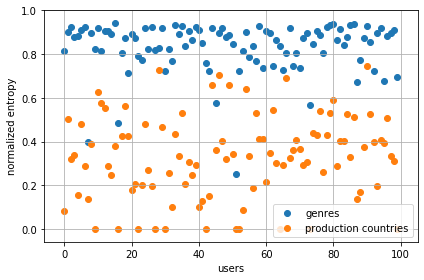

In [110]:
fig, ax = plt.subplots()
ax.set_xlabel('users')
ax.set_ylabel('normalized entropy')
ax.scatter(userid_tolerance_normed_df.index.values[:100], userid_tolerance_normed_df.genres[:100], label='genres')
ax.scatter(userid_tolerance_normed_df.index.values[:100], userid_tolerance_normed_df.production_countries[:100], label='production countries')
ax.legend()
ax.grid(True)
plt.tight_layout()
# plt.savefig('./plots/entropy_difference_ml_pro.png')
plt.show()

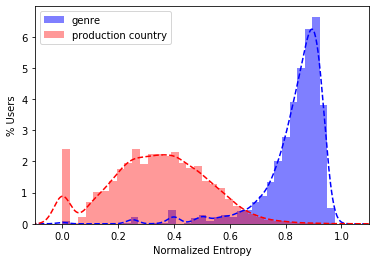

In [192]:
fig, ax = plt.subplots()
ax.hist(sorted(userid_tolerance_normed_df['genres']), color = 'blue', alpha=0.5,
             bins = int(180/5), label='genre', density=True)

ax.hist(sorted(userid_tolerance_normed_df['production_countries']), color = 'red',
             bins = int(180/5), alpha=0.4, label='production country', density=True)

plt.legend()
userid_tolerance_normed_df['genres'].plot.kde(ax=ax, legend=False, color='blue', ls='--')
userid_tolerance_normed_df['production_countries'].plot.kde(ax=ax, legend=False, color='red', ls='--')

ax.set_xlim([-0.1,1.1])
ax.set_xlabel('Normalized Entropy')
ax.set_ylabel('% Users')
plt.savefig('./plots/ml_user_entropy_distribitions_lineDist.png', dpi=300)

# 2. NMF RECSYS + MMR + TOLERANCE WEIGHTS

calcualte the tolerance matrix

In [78]:
user_genre_matrix = []
for userid, row in userid_tolerance_normed_df.iterrows():
    
    user_tolerance_vector = [0.0] * item_features_sampled_2.columns.values.shape[0]
    
    for feature in userid_tolerance_normed_df.columns.values.tolist():
        
        f_tol = userid_tolerance_normed_df.loc[userid, feature]
        
        sub_feat_indexes = [item_features_sampled_2.columns.get_loc(sf) for sf in feat_dict[feature]]
        
        for sf_id in sub_feat_indexes:
            user_tolerance_vector[sf_id] += f_tol
        
    # insert userid at the beginning of each vector
    user_tolerance_vector.insert(0, userid)
    user_genre_matrix.append(user_tolerance_vector)  
        
print (len(user_genre_matrix))
user_genre_matrix_df = pd.DataFrame(user_genre_matrix)
user_genre_matrix_df.columns = ['userid'] + item_features_sampled_2.columns.values.tolist()
user_genre_matrix_df.set_index('userid', inplace=True)
user_genre_matrix_df.head()


user_genre_matrix_df.to_csv('./data/user_genre_tol_matrix_normalized_ML.csv')

6000


In [79]:
print(userid_tolerance_normed[0][feature_names.index('genres')])
print (userid_tolerance_normed[0])
print(feature_names)

0.813692691170549
[8.13692691e-01 5.78067623e-01 2.22044605e-16 8.17693319e-02
 1.76382909e-01 1.37710126e-01 2.53346457e-01]
['genres', 'language', 'popularity', 'production_countries', 'revenue', 'runtime', 'year']


In [80]:
start = timeit.default_timer()
for lam in [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.87, 0.9, 0.93, 0.95, 0.97, 0.99, 1.0]:
    
    print(lam)
    top_k = 10
    mmr_tol_recs = []
    
    def compute_mmr(u):
        # get the user specific tolerance weight 
        w = user_genre_matrix_df.loc[u]
        return (u, mmr_opt(u, item_features_sampled_2, lam, top_k, w))

    pool = Pool(processes=5)
    mmr_tol_recs = pool.map(compute_mmr, list(range(dataset.user_n)))
    pool.close()
    pool.join()  
    
    save_recommendations(mmr_tol_recs, 'rec_tol_MMR_lam%s.csv'%lam)

stop = timeit.default_timer()
print('Process Time: %.2f secs' % (stop - start))

0.2
0.4
0.6
0.65
0.7
0.75
0.8
0.85
0.87
0.9
0.93
0.95
0.97
0.99
1.0
Process Time: 3700.63 secs


# 3. NMF RECSYS + MMR + TOLERANCE WEIGHTS + FAIRNESS WEIGHT

We have 323 features. In each category, go to the subcategories, find the proportions and usde them as weights.

In [82]:
feat_dict = {'genres': ['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie', 'Adult'], 'popularity': ['pop', 'notpop'], 'year': ['new', 'old'], 'revenue': ['high', 'low'], 'runtime': ['short', 'long'], 'language': ['en', 'fr', 'es', 'de', 'ru', 'la', 'nl', 'cn', 'zh', 'hu', 'sq', 'it', 'ko', 'fa', 'da', 'gd', 'ja', 'ar', 'hr', 'bs', 'mn', 'ro', 'id', 'ms', 'mk', 'sv', 'he', 'kw', 'cs', 'nv', 'mi', 'tl', 'pl', 'ga', 'no', 'sk', 'vi', 'yi', 'pt', 'hi', 'ca', 'is', 'af', 'sr', 'bn', 'wo', 'cy', 'th', 'lv', 'sw', 'bg', 'el', 'ne', 'tr', 'km', 'fi', 'eo', 'uk', 'iu', 'ka', 'sh', 'bo', 'nb', 'ty', 'xx', 'si', 'as', 'gn', 'eu', 'az', 'mt', 'ur', 'zu', 'lo', 'xh', 'bm', 'cr', 'ps', 'so', 'ku', 'hy', 'oc', 'pa', 'to', 'ce', 'qu', 'be', 'am', 'tg', 'tt', 'se', 'ml', 'ta', 'co', 'gl', 'dz', 'rw', 'ht', 'kk', 'ln', 'my', 'et', 'sa', 'lt', 'fy', 'tk', 'sl', 'te', 'ny', 'st', 'sc', 'gu', 'ff', 'mr', 'ug', 'ay', 'ky', 'jv', 'br', 'sg', 'lb', 'ab', 'kn', 'uz', 'sm', 'ki', 'tn', 'fo', 'sn', 'bi', 'ha', 'ig', 'mh'], 'production_countries': ['US', 'DE', 'GB', 'FR', 'IT', 'ES', 'CN', 'AU', 'ZA', 'CA', 'CH', 'BE', 'JP', 'IR', 'NL', 'HK', 'TN', 'IE', 'DO', 'HR', 'RU', 'MK', 'AT', 'TW', 'NZ', 'MX', 'PL', 'PE', 'CU', 'LI', 'DK', 'PT', 'FI', 'SE', 'AR', 'IS', 'KR', 'RS', 'HU', 'CZ', 'IN', 'BR', 'GR', 'CD', 'SN', 'BF', 'RO', 'PH', 'VN', 'TT', 'BG', 'CL', 'NO', 'KZ', 'DZ', 'LU', 'GE', 'UA', 'BW', 'AW', 'IL', 'TR', 'EC', 'LB', 'MA', 'BA', 'BS', 'MY', 'BT', 'JM', 'PK', 'NP', 'CI', 'TH', 'NA', 'CM', 'CO', 'XC', 'UY', 'SI', 'LY', 'PR', 'SU', 'XG', 'SG', 'AF', 'MT', 'PA', 'EG', 'ZW', 'TJ', 'UZ', 'CR', 'KW', 'MQ', 'GH', 'AM', 'ID', 'MN', 'BO', 'MC', 'IQ', 'SK', 'CS', 'VE', 'LT', 'RW', 'PS', 'TD', 'PY', 'QA', 'EE', 'MO', 'ML', 'UM', 'LV', 'AE', 'AZ', 'KY', 'NI', 'LR', 'YU', 'ME', 'AO', 'BY', 'KH', 'MR', 'CY', 'BD', 'SY', 'KG', 'AL', 'TZ', 'KP', 'KE', 'JO', 'UG', 'SA', 'SO', 'GT', 'MG', 'ET', 'LK', 'PG', 'NG', 'LA', 'PF', 'AN', 'CG', 'MM', 'BM', 'SV', 'TF', 'WS', 'MD', 'BB', 'AQ', 'GI', 'BN', 'HN', 'GN']}

In [83]:
item_features_sampled_2.head()

,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
Inner_ID,,,,,,,,,,,,,,,,,,,,,
2673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
12048,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4439,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
12943,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [84]:
# np.hstack(list(user_rr_recs_tol_allinclude.values()))

### calculating the percentage of items to come up with a probability/percentage vector

### Feature count of all the movies (items) in the whole data

In [85]:
items = list(range(dataset.item_n))
print(dataset.item_n)

training_item_features_df_unique = item_features_sampled_2[item_features_sampled_2.index.isin(items)]
training_item_features_df_unique.head()

14623


,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
Inner_ID,,,,,,,,,,,,,,,,,,,,,
2673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
12048,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4439,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
12943,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [86]:
all_item_feature_count = np.sum(training_item_features_df_unique.to_numpy(), axis=0)
all_item_feature_count = pd.DataFrame([all_item_feature_count], columns=training_item_features_df_unique.columns)
all_item_feature_count = pd.DataFrame(all_item_feature_count.T).rename(columns={0:'count'})
all_item_feature_count.index.name = 'cat'
all_item_feature_count.T

cat,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
count,13,2,1,3,0,1,0,44,65,269,...,20,19,0,38,3,4,56,37,262,7


In [87]:
freq_count = pd.DataFrame(columns=['cat', 'count'])

for key in feat_dict.keys():
    a_df = all_item_feature_count[all_item_feature_count.index.isin(feat_dict[key])]
    a_df_perc = a_df * 100.0 / a_df.sum() # divide by the total number of occurences in that catgory.
    a_df_perc = a_df_perc.reset_index(inplace=False)
    a_df_perc.columns = ['cat', 'count']
    freq_count = pd.concat([freq_count, a_df_perc], axis = 0)

freq_count.sort_values(by='cat', inplace=True)
freq_count.set_index('cat', inplace=True)
genre_all_item_count = freq_count

In [88]:
genre_all_item_count[genre_all_item_count.index.isin(feat_dict['genres'])].T

cat,Action,Adult,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
count,7.678329,0.0,4.831406,2.186391,14.958609,5.212149,2.140241,21.312989,3.498803,3.100753,...,1.623929,4.80833,1.721999,2.887306,7.770631,3.925697,0.317286,9.160922,1.349909,0.778794


In [89]:
genre_all_item_count[genre_all_item_count.index.isin(feat_dict['genres'])].sum()

count    100.0
dtype: float64

Text(0, 0.5, 'percentage')

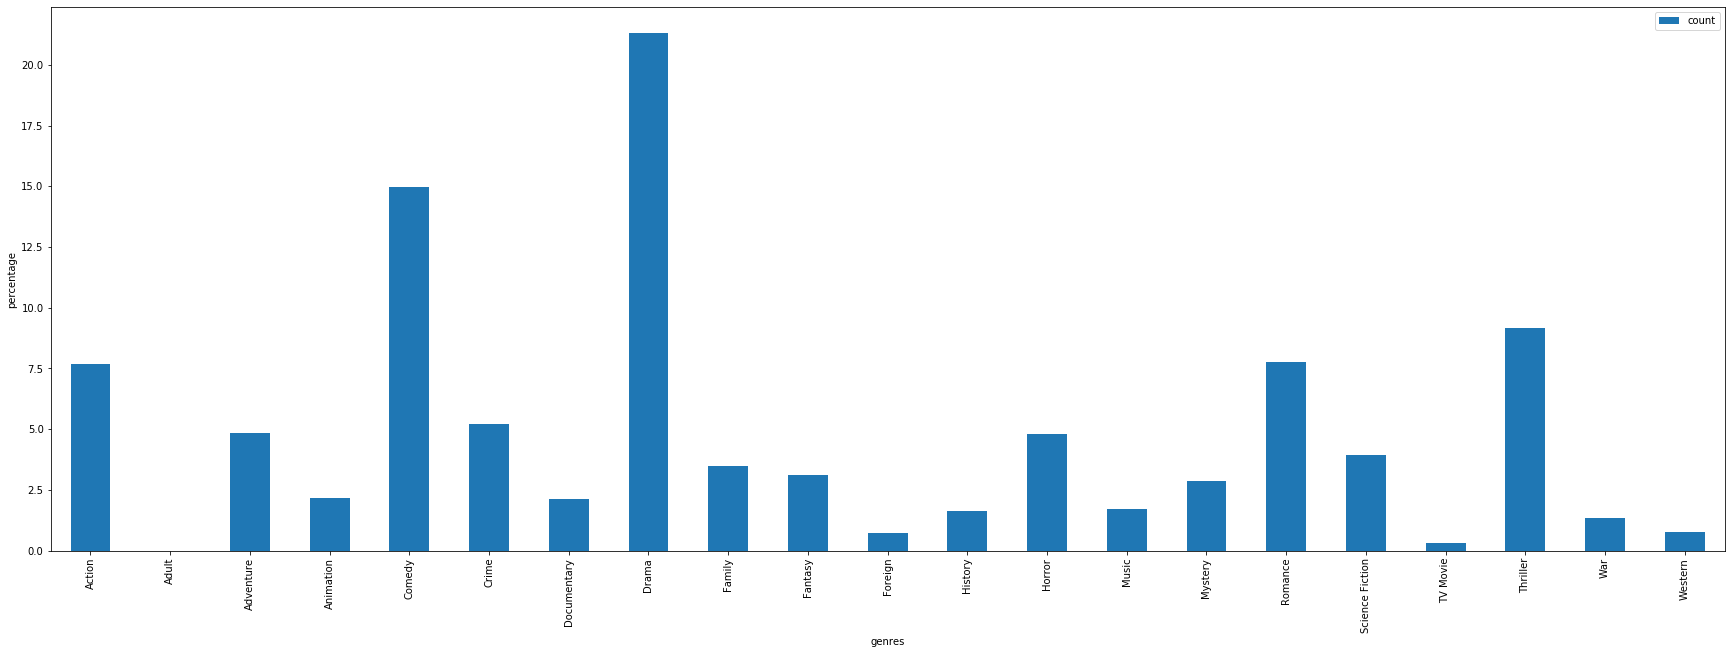

In [90]:
countries_df = genre_all_item_count[genre_all_item_count.index.isin(feat_dict['genres'])]
countries_df.plot(kind='bar', figsize=(30, 10))
plt.xlabel('genres')
plt.ylabel('percentage')

Text(0, 0.5, 'percentage')

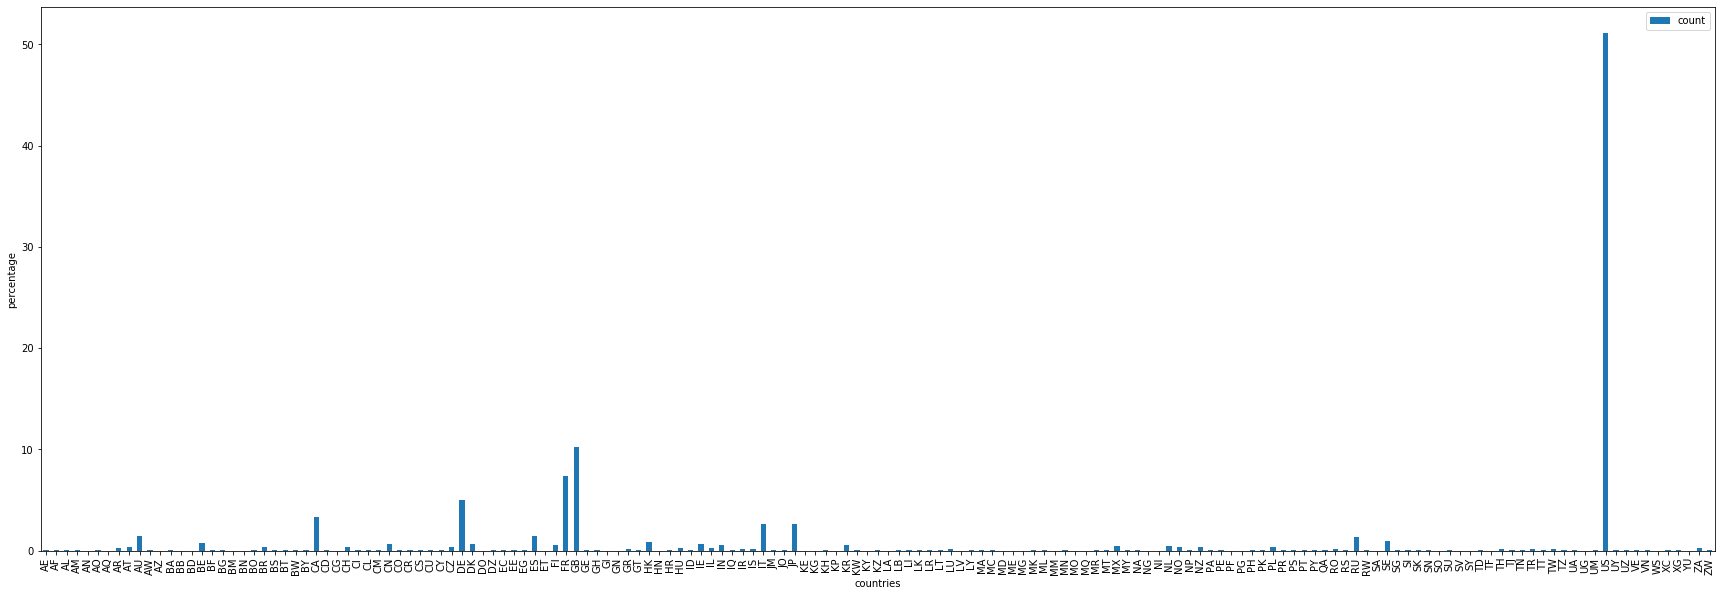

In [91]:
countries_df = genre_all_item_count[genre_all_item_count.index.isin(feat_dict['production_countries'])]
countries_df.plot(kind='bar', figsize=(30, 10))
plt.xlabel('countries')
plt.ylabel('percentage')

## multiple lambdas - selecting multiple genres and countries to increase their exposure

In [92]:
pd.set_option('display.max_columns', None)

# setting two dimensions's fairness weights

#### saving the country names into a file, since it's too long.

In [94]:
pd.DataFrame(feat_dict['production_countries']).to_csv('./data/countries.csv', index=False, header=None)

In [104]:
fairness_weights_man = genre_all_item_count.T.copy()
genre_dist_rerankings = []

fairness_weights_man[feat_dict['genres']] = 1
for fee in ['Horror', 'Music', 'History', 'Mystery']:
    fairness_weights_man[fee] = 100

fairness_weights_man[feat_dict['production_countries']] = 1
for fee in ['CA', 'DE', 'ES', 'HK']:
    fairness_weights_man[fee] = 100

fairness_weights_man = fairness_weights_man.T

In [106]:
fairness_weights_man.T

cat,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,AW,AZ,Action,Adult,Adventure,Animation,BA,BB,BD,BE,BF,BG,BM,BN,BO,BR,BS,BT,BW,BY,CA,CD,CG,CH,CI,CL,CM,CN,CO,CR,CS,CU,CY,CZ,Comedy,Crime,DE,DK,DO,DZ,Documentary,Drama,EC,EE,EG,ES,ET,FI,FR,Family,Fantasy,Foreign,GB,GE,GH,GI,GN,GR,GT,HK,HN,HR,HU,History,Horror,ID,IE,IL,IN,IQ,IR,IS,IT,JM,JO,JP,KE,KG,KH,KP,KR,KW,KY,KZ,LA,LB,LI,LK,LR,LT,LU,LV,LY,MA,MC,MD,ME,MG,MK,ML,MM,MN,MO,MQ,MR,MT,MX,MY,Music,Mystery,NA,NG,NI,NL,NO,NP,NZ,PA,PE,PF,PG,PH,PK,PL,PR,PS,PT,PY,QA,RO,RS,RU,RW,Romance,SA,SE,SG,SI,SK,SN,SO,SU,SV,SY,Science Fiction,TD,TF,TH,TJ,TN,TR,TT,TV Movie,TW,TZ,Thriller,UA,UG,UM,US,UY,UZ,VE,VN,WS,War,Western,XC,XG,YU,ZA,ZW,ab,af,am,ar,as,ay,az,be,bg,bi,bm,bn,bo,br,bs,ca,ce,cn,co,cr,cs,cy,da,de,dz,el,en,eo,es,et,eu,fa,ff,fi,fo,fr,fy,ga,gd,gl,gn,gu,ha,he,hi,high,hr,ht,hu,hy,id,ig,is,it,iu,ja,jv,ka,ki,kk,km,kn,ko,ku,kw,ky,la,lb,ln,lo,long,low,lt,lv,mh,mi,mk,ml,mn,mr,ms,mt,my,nb,ne,new,nl,no,notpop,nv,ny,oc,old,pa,pl,pop,ps,pt,qu,ro,ru,rw,sa,sc,se,sg,sh,short,si,sk,sl,sm,sn,so,sq,sr,st,sv,sw,ta,te,tg,th,tk,tl,tn,to,tr,tt,ty,ug,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,1.0,1.0,1.0,100.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.070472,0.010067,0.760093,0.005034,0.0,0.015101,0.005034,0.050337,0.0,0.015101,0.030202,0.045304,0.005034,0.04027,0.050337,0.015101,0.699688,0.010067,0.015101,0.538609,0.035236,0.392631,4.953186,0.0,0.286922,58.904661,0.025169,4.771972,0.035236,0.025169,0.25672,0.005034,0.523508,0.0,7.797242,0.0,0.090607,0.08054,0.010067,0.010067,0.015101,0.0,0.397664,0.478204,26.97931,0.04027,0.0,0.760093,0.045304,0.030202,0.0,0.090607,3.422934,0.025169,2.728279,0.010067,0.055371,0.0,0.010067,0.025169,0.015101,0.59398,0.030202,0.005034,0.0,0.568811,0.0,0.005034,0.005034,65.813793,73.02069,0.015101,0.005034,0.0,0.030202,0.015101,0.005034,0.020135,0.010067,0.020135,0.005034,0.010067,0.005034,0.005034,69.606897,0.302024,0.236585,34.268966,0.025169,0.005034,0.015101,30.393103,0.035236,0.704722,65.731034,0.030202,0.971509,0.015101,0.156046,3.010168,0.005034,0.010067,0.005034,0.005034,0.005034,0.050337,34.186207,0.005034,0.045304,0.005034,0.0,0.0,0.030202,0.055371,0.156046,0.005034,0.855733,0.070472,0.030202,0.035236,0.005034,0.362428,0.0,0.055371,0.0,0.005034,0.347327,0.005034,0.005034,0.0,0.100675,0.095641,0.0,0.191282,0.015101,0.020135,0.281889,0.186248,1.318836,0.035236


### NMF RECSYS + MMR + Fairness Weights

In [107]:
start = timeit.default_timer()
for lam in [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.87, 0.9, 0.93, 0.95, 0.97, 0.99, 1.0]:
    
    print(lam)
    top_k = 10

    def compute_mmr_selective_fairness(u):
        
        f_w = fairness_weights_man.T.to_numpy()[0]
        return (u, mmr_opt(u, item_features_sampled_2, lam, top_k, f_w))

    pool = Pool(processes=20) 
    user_recs_ent_fairness = pool.map(compute_mmr_selective_fairness, list(range(dataset.user_n)))
    pool.close()
    pool.join()
    pool.terminate()

    save_recommendations(user_recs_ent_fairness, 'rec_MMR_fair_lam%s_Genre&Country.csv'%lam)

stop = timeit.default_timer()
print('Process Time: %.2f secs' % (stop - start))

0.2
0.4
0.6
0.65
0.7
0.75
0.8
0.85
0.87
0.9
0.93
0.95
0.97
0.99
1.0
Process Time: 1985.54 secs


In [108]:
user_recs_ent_fairness_allinclude_selective = {}
for x in user_recs_ent_fairness: # be careful to change this
    user_recs_ent_fairness_allinclude_selective[x[0]] = x[1][1]
    
p = []
r = []
n = []
ild = []
ent = []
for u in user_tests.keys():
    if len(user_tests[u]) > 0:

        test_items = [t[0] for t in user_tests[u] if t[1] >= 4]

        if len(test_items) > 0:
            # top items
            top_items = user_recs_ent_fairness_allinclude_selective[u]

            recall = Recall(test_items, top_items)
            precision = Precision(test_items, top_items)
            ndcg = nDCG_Time(test_items, top_items)

            p.append(precision)
            r.append(recall)
            n.append(ndcg)

print (" precision %.3f\n recall %.3f\n nDCG %.3f" %
       (np.average(p),np.average(r),np.average(n)))

 precision 0.164
 recall 0.197
 nDCG 0.130
 ILD 0.683
 ENTROPY 2.886


# OFAR: NMF RECSYS + MMR + fair weights + tolerance weights

In [100]:
fairness_weights_man.T.head(1)

cat,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,AW,AZ,Action,Adult,Adventure,Animation,BA,BB,BD,BE,BF,BG,BM,BN,BO,BR,BS,BT,BW,BY,CA,CD,CG,CH,CI,CL,CM,CN,CO,CR,CS,CU,CY,CZ,Comedy,Crime,DE,DK,DO,DZ,Documentary,Drama,EC,EE,EG,ES,ET,FI,FR,Family,Fantasy,Foreign,GB,GE,GH,GI,GN,GR,GT,HK,HN,HR,HU,History,Horror,ID,IE,IL,IN,IQ,IR,IS,IT,JM,JO,JP,KE,KG,KH,KP,KR,KW,KY,KZ,LA,LB,LI,LK,LR,LT,LU,LV,LY,MA,MC,MD,ME,MG,MK,ML,MM,MN,MO,MQ,MR,MT,MX,MY,Music,Mystery,NA,NG,NI,NL,NO,NP,NZ,PA,PE,PF,PG,PH,PK,PL,PR,PS,PT,PY,QA,RO,RS,RU,RW,Romance,SA,SE,SG,SI,SK,SN,SO,SU,SV,SY,Science Fiction,TD,TF,TH,TJ,TN,TR,TT,TV Movie,TW,TZ,Thriller,UA,UG,UM,US,UY,UZ,VE,VN,WS,War,Western,XC,XG,YU,ZA,ZW,ab,af,am,ar,as,ay,az,be,bg,bi,bm,bn,bo,br,bs,ca,ce,cn,co,cr,cs,cy,da,de,dz,el,en,eo,es,et,eu,fa,ff,fi,fo,fr,fy,ga,gd,gl,gn,gu,ha,he,hi,high,hr,ht,hu,hy,id,ig,is,it,iu,ja,jv,ka,ki,kk,km,kn,ko,ku,kw,ky,la,lb,ln,lo,long,low,lt,lv,mh,mi,mk,ml,mn,mr,ms,mt,my,nb,ne,new,nl,no,notpop,nv,ny,oc,old,pa,pl,pop,ps,pt,qu,ro,ru,rw,sa,sc,se,sg,sh,short,si,sk,sl,sm,sn,so,sq,sr,st,sv,sw,ta,te,tg,th,tk,tl,tn,to,tr,tt,ty,ug,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
count,0.07061,0.010863,0.005432,0.016295,0.0,0.005432,0.0,0.238988,0.35305,1.461083,0.010863,0.0,1.0,1.0,1.0,1.0,0.038021,0.0,0.0,0.787573,0.021726,0.054315,0.0,0.0,0.005432,0.315029,0.016295,0.005432,0.010863,0.005432,3.3241,0.005432,0.0,0.385639,0.005432,0.065178,0.010863,0.613764,0.027158,0.005432,0.005432,0.021726,0.010863,0.309598,1.0,1.0,4.98615,0.668079,0.0,0.027158,1.0,1.0,0.016295,0.032589,0.016295,1.455652,0.0,0.586606,7.354299,1.0,1.0,1.0,10.254739,0.048884,0.005432,0.0,0.0,0.179241,0.005432,0.88534,0.0,0.038021,0.222693,100.0,100.0,0.027158,0.678942,0.206398,0.548585,0.005432,0.190104,0.130357,2.579979,0.016295,0.005432,2.666884,0.0,0.0,0.010863,0.0,0.499701,0.005432,0.0,0.021726,0.0,0.032589,0.010863,0.005432,0.005432,0.021726,0.190104,0.0,0.010863,0.059747,0.010863,0.0,0.0,0.0,0.021726,0.005432,0.0,0.005432,0.0,0.0,0.005432,0.032589,0.439954,0.010863,100.0,100.0,0.010863,0.0,0.0,0.49427,0.336755,0.005432,0.309598,0.005432,0.038021,0.0,0.0,0.038021,0.016295,0.325892,0.016295,0.005432,0.076041,0.010863,0.027158,0.14122,0.097768,1.363315,0.010863,1.0,0.0,0.977676,0.059747,0.016295,0.027158,0.010863,0.0,0.027158,0.0,0.0,1.0,0.005432,0.0,0.152083,0.005432,0.038021,0.162946,0.005432,1.0,0.162946,0.005432,1.0,0.081473,0.0,0.005432,51.137907,0.016295,0.005432,0.010863,0.027158,0.0,1.0,1.0,0.010863,0.005432,0.0,0.238988,0.005432,0.0,0.070472,0.010067,0.760093,0.005034,0.0,0.015101,0.005034,0.050337,0.0,0.015101,0.030202,0.045304,0.005034,0.04027,0.050337,0.015101,0.699688,0.010067,0.015101,0.538609,0.035236,0.392631,4.953186,0.0,0.286922,58.904661,0.025169,4.771972,0.035236,0.025169,0.25672,0.005034,0.523508,0.0,7.797242,0.0,0.090607,0.08054,0.010067,0.010067,0.015101,0.0,0.397664,0.478204,26.97931,0.04027,0.0,0.760093,0.045304,0.030202,0.0,0.090607,3.422934,0.025169,2.728279,0.010067,0.055371,0.0,0.010067,0.025169,0.015101,0.59398,0.030202,0.005034,0.0,0.568811,0.0,0.005034,0.005034,65.813793,73.02069,0.015101,0.005034,0.0,0.030202,0.015101,0.005034,0.020135,0.010067,0.020135,0.005034,0.010067,0.005034,0.005034,69.606897,0.302024,0.236585,34.268966,0.025169,0.005034,0.015101,30.393103,0.035236,0.704722,65.731034,0.030202,0.971509,0.015101,0.156046,3.010168,0.005034,0.010067,0.005034,0.005034,0.005034,0.050337,34.186207,0.005034,0.045304,0.005034,0.0,0.0,0.030202,0.055371,0.156046,0.005034,0.855733,0.070472,0.030202,0.035236,0.005034,0.362428,0.0,0.055371,0.0,0.005034,0.347327,0.005034,0.005034,0.0,0.100675,0.095641,0.0,0.191282,0.015101,0.020135,0.281889,0.186248,1.318836,0.035236


In [101]:
user_genre_matrix_df.head(1)

,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,AW,AZ,Action,Adult,Adventure,Animation,BA,BB,BD,BE,BF,BG,BM,BN,BO,BR,BS,BT,BW,BY,CA,CD,CG,CH,CI,CL,CM,CN,CO,CR,CS,CU,CY,CZ,Comedy,Crime,DE,DK,DO,DZ,Documentary,Drama,EC,EE,EG,ES,ET,FI,FR,Family,Fantasy,Foreign,GB,GE,GH,GI,GN,GR,GT,HK,HN,HR,HU,History,Horror,ID,IE,IL,IN,IQ,IR,IS,IT,JM,JO,JP,KE,KG,KH,KP,KR,KW,KY,KZ,LA,LB,LI,LK,LR,LT,LU,LV,LY,MA,MC,MD,ME,MG,MK,ML,MM,MN,MO,MQ,MR,MT,MX,MY,Music,Mystery,NA,NG,NI,NL,NO,NP,NZ,PA,PE,PF,PG,PH,PK,PL,PR,PS,PT,PY,QA,RO,RS,RU,RW,Romance,SA,SE,SG,SI,SK,SN,SO,SU,SV,SY,Science Fiction,TD,TF,TH,TJ,TN,TR,TT,TV Movie,TW,TZ,Thriller,UA,UG,UM,US,UY,UZ,VE,VN,WS,War,Western,XC,XG,YU,ZA,ZW,ab,af,am,ar,as,ay,az,be,bg,bi,bm,bn,bo,br,bs,ca,ce,cn,co,cr,cs,cy,da,de,dz,el,en,eo,es,et,eu,fa,ff,fi,fo,fr,fy,ga,gd,gl,gn,gu,ha,he,hi,high,hr,ht,hu,hy,id,ig,is,it,iu,ja,jv,ka,ki,kk,km,kn,ko,ku,kw,ky,la,lb,ln,lo,long,low,lt,lv,mh,mi,mk,ml,mn,mr,ms,mt,my,nb,ne,new,nl,no,notpop,nv,ny,oc,old,pa,pl,pop,ps,pt,qu,ro,ru,rw,sa,sc,se,sg,sh,short,si,sk,sl,sm,sn,so,sq,sr,st,sv,sw,ta,te,tg,th,tk,tl,tn,to,tr,tt,ty,ug,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.813693,0.813693,0.813693,0.813693,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.813693,0.813693,0.081769,0.081769,0.081769,0.081769,0.813693,0.813693,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.813693,0.813693,0.813693,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.813693,0.813693,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.813693,0.813693,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.813693,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.813693,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.813693,0.081769,0.081769,0.813693,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.081769,0.813693,0.813693,0.081769,0.081769,0.081769,0.081769,0.081769,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.176383,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.13771,0.176383,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.253346,0.578068,0.578068,2.220446e-16,0.578068,0.578068,0.578068,0.253346,0.578068,0.578068,2.220446e-16,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.578068,0.57

In [109]:
start = timeit.default_timer()
for lam in [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85,0.87, 0.9,0.93, 0.95, 0.97, 0.99, 1.0]:
    
    print(lam)
    top_k = 10

    def compute_mmr_selective_fairness(u):
        
        # get the user specific tolerance weight 
        u_tol_w = fairness_weights_man.T.to_numpy()[0] * user_genre_matrix_df.loc[u].to_numpy()
        
        return (u, mmr_opt(u, item_features_sampled_2, lam, top_k, u_tol_w))


    pool = Pool(processes=20)
    user_recs_ent_fairness = pool.map(compute_mmr_selective_fairness, list(range(dataset.user_n)))
    pool.close()
    pool.join()
    pool.terminate()

    save_recommendations(user_recs_ent_fairness, 'rec_tol_fair_MMR_lam%s_Genre&Country.csv'%lam)

stop = timeit.default_timer()
print('Process Time: %.2f secs' % (stop - start))

0.2
0.4
0.6
0.65
0.7
0.75
0.8
0.85
0.87
0.9
0.93
0.95
0.97
0.99
1.0
Process Time: 1954.63 secs
